<a href="https://colab.research.google.com/github/Alan-Cheong/IEEE_QW_2020/blob/master/QAOA_Ruslan_Shaydulin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 11.4 MB/s eta 0:00:00


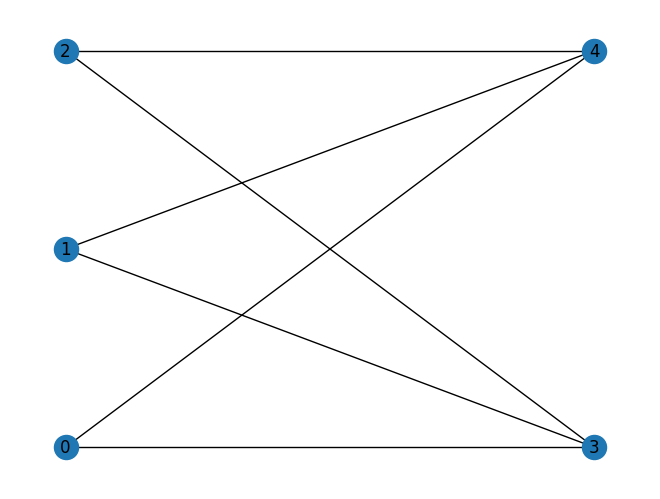

In [2]:
# import warnings; warnings.filterwarnings("ignore")
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from operator import itemgetter
from scipy.optimize import minimize
from qiskit.providers.basic_provider import BasicProvider
#backend = BasicProvider().get_backend("backend_name")
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
#from qiskit.aqua.algorithms import NumPyEigensolver
from qiskit.quantum_info import Pauli
#from qiskit.aqua.operators import op_converter
#from qiskit.aqua.operators import WeightedPauliOperator

G = nx.Graph()
G.add_edges_from([[0,3],[0,4],[1,3],[1,4],[2,3],[2,4]])
pos = nx.bipartite_layout(G, [0, 1, 2])
nx.draw(G, pos)

#[0, 1, 2]: This is the list of nodes that belong to one of the two sets of the bipartite graph.
#The other set of nodes is inferred by the graph.
#In your graph, nodes 0, 1, 2 form one set, and nodes 3, 4 form the other set, as they are connected by edges to 0, 1, 2.

#pos: This is the output of the function, which is a dictionary of positions.
#It tells the drawing function where to place each node in a 2D space for plotting.

labels = {node: str(node) for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=12, font_color="black")

# Show the plot
plt.show()

In [3]:
def append_zz_term(qc, q1, q2, gamma):
    qc.cx(q1,q2)
    qc.rz(2*gamma, q2)
    qc.cx(q1,q2)

def get_cost_operator_circuit(G, gamma):
    N = G.number_of_nodes()

    qc = QuantumCircuit(N,N)
    for i, j in G.edges():
        append_zz_term(qc, i, j, gamma)
    return qc

qc = get_cost_operator_circuit(G, np.pi / 3)
qc.draw()

»
q_0: ──■────────────────■────■────────────────────────────■─────────────────»
       │                │    │     ┌───┐    ┌──────────┐  │  ┌───┐     ┌───┐»
q_1: ──┼────────────────┼────┼─────┤ X ├────┤ Rz(2π/3) ├──┼──┤ X ├─────┤ X ├»
       │                │    │     └─┬─┘    └──────────┘  │  └─┬─┘┌───┐└─┬─┘»
q_2: ──┼────────────────┼────┼───────┼────────────────────┼────┼──┤ X ├──┼──»
     ┌─┴─┐┌──────────┐┌─┴─┐  │       │                    │    │  └─┬─┘  │  »
q_3: ┤ X ├┤ Rz(2π/3) ├┤ X ├──┼───────■────────────────────┼────■────■────┼──»
     └───┘└──────────┘└───┘┌─┴─┐┌──────────┐            ┌─┴─┐            │  »
q_4: ──────────────────────┤ X ├┤ Rz(2π/3) ├────────────┤ X ├────────────■──»
                           └───┘└──────────┘            └───┘               »
c: 5/═══════════════════════════════════════════════════════════════════════»
                                                                            »
«                                                 
«q_0: ────────────────────────────────────────────
«     ┌──────────┐     ┌───┐                      
«q_1: ┤ Rz(2π/3) ├─────┤ X ├──────────────────────
«     ├──────────┤┌───┐└─┬─┘┌───┐┌──────────┐┌───┐
«q_2: ┤ Rz(2π/3) ├┤ X ├──┼──┤ X ├┤ Rz(2π/3) ├┤ X ├
«     └──────────┘└─┬─┘  │  └─┬─┘└──────────┘└─┬─┘
«q_3: ──────────────■────┼────┼────────────────┼──
«                        │    │                │  
«q_4: ───────────────────■────■────────────────■──
«                                                 
«c: 5/════════════════════════════════════════════
«

In [4]:
def append_x_term(qc, q1, beta):
    qc.rx(2*beta, q1)

def get_mixer_operator_circuit(G, beta):
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    for n in G.nodes():
        append_x_term(qc, n, beta)
    return qc

qc = get_mixer_operator_circuit(G, np.pi/3)
qc.draw()

┌──────────┐
q_0: ┤ Rx(2π/3) ├
     ├──────────┤
q_1: ┤ Rx(2π/3) ├
     ├──────────┤
q_2: ┤ Rx(2π/3) ├
     ├──────────┤
q_3: ┤ Rx(2π/3) ├
     ├──────────┤
q_4: ┤ Rx(2π/3) ├
     └──────────┘
c: 5/════════════

In [5]:
def get_qaoa_circuit(G, beta, gamma):
    #assert(len(beta) == len(gamma))
    p = len(beta) # infering number of QAOA steps from the parameters passed

    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    # first, apply a layer of Hadamards
    qc.h(range(N))
    # second, apply p alternating operators
    for i in range(p):
        qc = qc.compose(get_cost_operator_circuit(G,gamma[i])).compose(get_mixer_operator_circuit(G,beta[i]))
        # finally, do not forget to measure the result!
    qc.barrier(range(N))
    qc.measure(range(N), range(N))
    qc.draw()
    return qc

qc = get_qaoa_circuit(G,[np.pi/3], [np.pi/2])
qc.draw()

┌───┐                                               ┌──────────┐          »
q_0: ┤ H ├──■─────────────■────■──────────────────────■──┤ Rx(2π/3) ├──────────»
     ├───┤  │             │    │    ┌───┐  ┌───────┐  │  └──┬───┬───┘     ┌───┐»
q_1: ┤ H ├──┼─────────────┼────┼────┤ X ├──┤ Rz(π) ├──┼─────┤ X ├─────────┤ X ├»
     ├───┤  │             │    │    └─┬─┘  └───────┘  │     └─┬─┘    ┌───┐└─┬─┘»
q_2: ┤ H ├──┼─────────────┼────┼──────┼───────────────┼───────┼──────┤ X ├──┼──»
     ├───┤┌─┴─┐┌───────┐┌─┴─┐  │      │               │       │      └─┬─┘  │  »
q_3: ┤ H ├┤ X ├┤ Rz(π) ├┤ X ├──┼──────■───────────────┼───────■────────■────┼──»
     ├───┤└───┘└───────┘└───┘┌─┴─┐┌───────┐         ┌─┴─┐                   │  »
q_4: ┤ H ├───────────────────┤ X ├┤ Rz(π) ├─────────┤ X ├───────────────────■──»
     └───┘                   └───┘└───────┘         └───┘                      »
c: 5/══════════════════════════════════════════════════════════════════════════»
                                                                               »
«                                                                  ░ ┌─┐      »
«q_0: ─────────────────────────────────────────────────────────────░─┤M├──────»
«     ┌───────┐     ┌───┐┌──────────┐                              ░ └╥┘┌─┐   »
«q_1: ┤ Rz(π) ├─────┤ X ├┤ Rx(2π/3) ├──────────────────────────────░──╫─┤M├───»
«     ├───────┤┌───┐└─┬─┘└──┬───┬───┘ ┌───────┐  ┌───┐┌──────────┐ ░  ║ └╥┘┌─┐»
«q_2: ┤ Rz(π) ├┤ X ├──┼─────┤ X ├─────┤ Rz(π) ├──┤ X ├┤ Rx(2π/3) ├─░──╫──╫─┤M├»
«     └───────┘└─┬─┘  │     └─┬─┘    ┌┴───────┴─┐└─┬─┘└──────────┘ ░  ║  ║ └╥┘»
«q_3: ───────────■────┼───────┼──────┤ Rx(2π/3) ├──┼───────────────░──╫──╫──╫─»
«                     │       │      └──────────┘  │  ┌──────────┐ ░  ║  ║  ║ »
«q_4: ────────────────■───────■────────────────────■──┤ Rx(2π/3) ├─░──╫──╫──╫─»
«                                                     └──────────┘ ░  ║  ║  ║ »
«c: 5/════════════════════════════════════════════════════════════════╩══╩══╩═»
«                                                                     0  1  2 »
«           
«q_0: ──────
«           
«q_1: ──────
«           
«q_2: ──────
«     ┌─┐   
«q_3: ┤M├───
«     └╥┘┌─┐
«q_4: ─╫─┤M├
«      ║ └╥┘
«c: 5/═╩══╩═
«      3  4

In [6]:
def invert_counts(counts):
    return {k[::-1]:v for k, v in counts.items()}

In [7]:
backend = BasicProvider().get_backend('basic_simulator')
new_circuit = transpile(qc, backend)
job = backend.run(new_circuit)
#job = execute(qc, backend)
result = job.result()
print(invert_counts(result.get_counts()))

{'00111': 26, '01100': 36, '10010': 29, '10100': 30, '00001': 28, '01001': 34, '00011': 34, '11001': 30, '00101': 32, '00110': 37, '10110': 25, '11100': 37, '11011': 39, '11000': 28, '10101': 30, '11110': 20, '11010': 37, '01011': 31, '00010': 28, '10111': 36, '10001': 34, '11101': 35, '11111': 37, '10011': 29, '01110': 45, '01101': 33, '00100': 34, '01010': 24, '01000': 32, '00000': 29, '01111': 35, '10000': 30}


In [8]:
def maxcut_obj(x,G):
    cut = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            # the edge is cut
            cut -= 1
    return cut

maxcut_obj('00011', G)

print(maxcut_obj('00011',G))

-6


In [9]:
def compute_maxcut_energy(counts, G):
    energy = 0
    total_counts = 0
    for meas, meas_count in counts.items():
        obj_for_meas = maxcut_obj(meas, G)
        energy += obj_for_meas * meas_count
        total_counts += meas_count
    return energy / total_counts

compute_maxcut_energy(invert_counts(result.get_counts()), G)

-2.9892578125

In [10]:
from qiskit.quantum_info import SparsePauliOp
import qiskit.qasm3
def get_black_box_objective(G,p):
    backend = BasicProvider().get_backend('basic_simulator')
    def f(theta):
        # let's assume first half is betas, second half is gammas
        beta = theta[:p]
        gamma = theta[p:]
        qc = get_qaoa_circuit(G,beta, gamma)
        counts = backend.run(qc, seed_simulator=10).result().get_counts()
        # return the energy
        return compute_maxcut_energy(invert_counts(counts), G)
    return f

# p is the number of QAOA alternating operators
p = 5
obj = get_black_box_objective(G, p)

init_point = np.array([0.81069872, 2.2067517 , 0.83830696, 2.15579759, 0.37060699,
       2.42068091, 6.1575306 , 2.2453419 , 3.85060091, 6.137845  ])
# We are going to limit the number of iterations to 2500
res_sample = minimize(obj, init_point, method='COBYLA', options={'maxiter':2500, 'disp': True})
res_sample

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.76171875
       x: [ 1.938e+00  2.212e+00  2.027e+00  2.064e+00  3.811e-01
            2.223e+00  6.162e+00  2.296e+00  3.582e+00  5.965e+00]
    nfev: 168
   maxcv: 0.0

In [11]:
from qiskit import transpile
from qiskit.primitives import BackendSampler
optimal_theta = res_sample['x']
qc = get_qaoa_circuit(G, optimal_theta[:p], optimal_theta[p:])
#counts = invert_counts(execute(qc, backend).result().get_counts()) <------ This command is deprecated because 'execute' is no longer used in Ver 1.0
new_circuit = transpile(qc, backend)
counts = invert_counts(backend.run(new_circuit).result().get_counts())

counts

{'11100': 467,
 '00011': 476,
 '11000': 9,
 '01100': 8,
 '00100': 2,
 '01111': 2,
 '01011': 3,
 '10011': 7,
 '00001': 2,
 '10001': 2,
 '10100': 11,
 '01101': 1,
 '01000': 4,
 '01010': 1,
 '10101': 1,
 '11111': 4,
 '00111': 7,
 '11011': 4,
 '10000': 1,
 '10010': 1,
 '11001': 2,
 '01001': 1,
 '11101': 2,
 '10111': 1,
 '10110': 1,
 '00110': 2,
 '00010': 1,
 '00101': 1}

<BarContainer object of 5 artists>

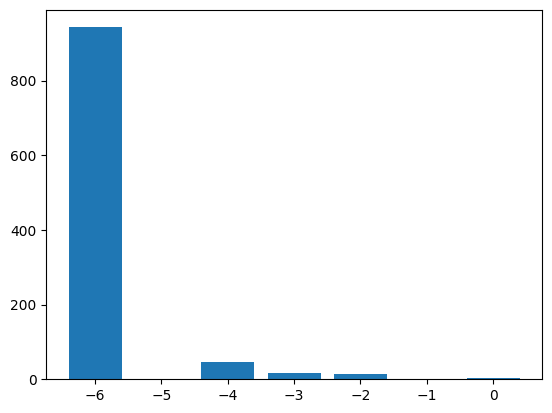

In [12]:
energies = defaultdict(int)
for k, v in counts.items():
    energies[maxcut_obj(k,G)] += v

x,y = zip(*energies.items())
plt.bar(x,y)

Best string: 11100 with cut: 6


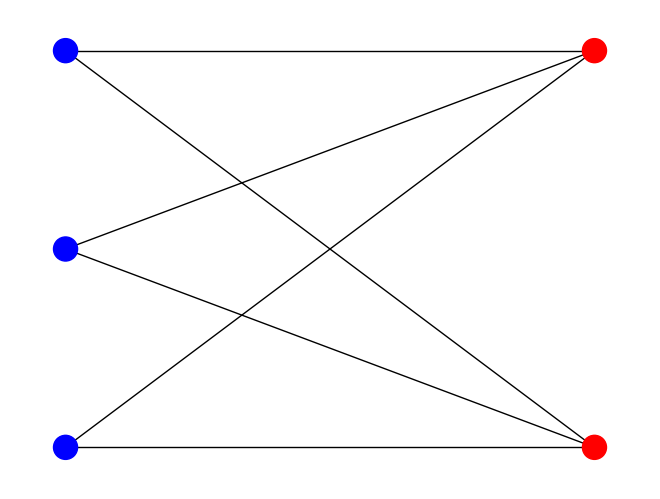

In [13]:
# get the best solution:
best_cut, best_solution = min([(maxcut_obj(x,G),x) for x in counts.keys()], key=itemgetter(0))
print(f"Best string: {best_solution} with cut: {-best_cut}")

# color the graph nodes by part
colors = ['r' if best_solution[node] == '0' else 'b' for node in G]
nx.draw(G,node_color = colors, pos=nx.bipartite_layout(G, [0,1,2]))